# Sitcoms 2: Exploratory Data Analysis.

This is the Second of Four notebooks completed on Sitcom Pilot Script Data. In this notebook, I will open the sitcom pilot data that we obtained and cleaned in [Notebook 1 - Obtain/Clean](1_sitcoms_clean.ipynb) and explore it by generating visualizations and analyzing statistics. I will also take some time for feature engineering to prepare for our two modeling notebooks: [Notebook 3 - Classification](3_sitcoms_classification.ipynb) and [Notebook 4 - Deep Learning](4_sitcoms_deep_learning.ipynb).

## Table of Contents

  * 1. [Introduction](#intro)  
      * 1.1. [Import Libraries](#import)  
      * 1.2. [Open and Preview Data](#open)   
  * 2. [Basic Data Exploration](#basic)  
      * 2.1. [By The Numbers](#numbers)  
      * 2.2. [Distributions](#dist)  
      * 2.3. [Interactions](#interactions)    
  * 3. [EDA with Text Data](#text)  
      * 3.1. [Generating WordClouds](#wordclouds)
            * 3.1.1. [Successful Pilots](#success)
            * 3.1.2. [Unsuccessful Pilots](#fail)
      * 3.2. [Latent Dirichlet Allocation (LDA](#lda)
  * 4. [Feature Engineering](#feat)  
      * 4.1. [Basic Feature Engineering](#bfe)  
      * 4.2. [More Complex Features](#complex)
            * 4.2.1. [Profanity](#profanity)
            * 4.2.2. [Character Names](#human)
            * 4.2.3. [Part of Speech Tags](#pos)
      * 4.3.  [Confusion Matrix for New Features](#confuse)  

<a id='intro'></a>

# 1. Introduction

<a id='import'></a>

### 1.1. Import Libraries

In [1]:
#import necessary libaries

#dataframes
import pandas as pd

#math
import numpy as np
np.random.seed(0)

#visualizations
import seaborn as sns

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import plotly #import plotly for visualization
from plotly import tools
from plotly.offline import init_notebook_mode, iplot #display in notebook
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline

#nlp
import re
import string
from html.parser import HTMLParser
from tqdm import tqdm

from collections import defaultdict

#pre-processing
import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#lda
from sklearn.decomposition import LatentDirichletAllocation

#wordcloud mask
from PIL import Image
#wordcloud
from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec

# spacy for lemmatization
import spacy

import warnings
warnings.filterwarnings("ignore")

C:\Users\Emily\Anaconda3\Newfolder\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



<a id='open'></a>

### 1.2. Open and Preview Data

In [2]:
df = pd.read_csv('sitcoms.csv') #open and read original df

In [3]:
df_raw = pd.read_csv('pilotdata.csv') #open and read raw script df

In [4]:
data_text = pd.read_csv('scripts.csv') #open and read clean script df

<a id='basic'></a>

# 2. Basic Data Exploration

Let's explore the data to get a better understanding of it as well as see if we find anything interesting.

In [5]:
#split the data based on label
bad = df.loc[df.label=='fail'] #unsuccessful shows
good = df.loc[df.label=='success'] #successful shows

<a id='numbers'></a>

### 2.1. By the Numbers

Let's get some numerical data on the average performance of our successful and unsuccessful sitcoms

In [6]:
goodrt = round(good['rtscore'].mean(), 2) #round scores
badrt = round(bad['rtscore'].mean(), 2)
print ("Average Rotten Tomatoes Score for Successful Sitcoms:", goodrt) #print scores
print ("Average Rotten Tomatoes Score for Failed Sitcoms:", badrt)

Average Rotten Tomatoes Score for Successful Sitcoms: 88.93
Average Rotten Tomatoes Score for Failed Sitcoms: 15.33


In [7]:
goodimdb = round(good['IMDB'].mean(), 2) #round scores
badimdb = round(bad['IMDB'].mean(), 2)
print ("Average IMDB Score for Successful Sitcoms:", goodimdb)
print ("Average IMDB Score for Failed Sitcoms:", badimdb)

Average IMDB Score for Successful Sitcoms: 8.18
Average IMDB Score for Failed Sitcoms: 5.17


In [8]:
goodep = round(good['episodes'].mean(), 2) #round scores
badep = round(bad['episodes'].mean(), 2)
print ("Average Number of Episodes for Successful Sitcoms:", goodep)
print ("Average Number of Episodes for Failed Sitcoms:", badep)

Average Number of Episodes for Successful Sitcoms: 168.3
Average Number of Episodes for Failed Sitcoms: 9.0


There is a clear difference between our failed shows and successful shows. This was of course expected as I picked shows to include based on their Rotten Tomatoes and IMDB scores. However, it is still interesting just how different the averages between labels are.

It's also interesting that there is a much bigger difference between rotten tomatoes scores of failed and successful shows than there is between the IMDB scores between failed and successful shows. I think this may have something to do with the fact that rotten tomatoes scores are largely made up of film critic reviews while IMDB reviews typically represent audience opinions of a show. Audiences tend to be much more forgiving of "bad" writing or acting and on the flip side, they also tend to care less about the "special nuances" that a critic may praise in a successful program.

The episodes variable has the largest difference between averages. This is probably because a couple heavy hitters in the successful label have inflated their average, such as The Simpons, which has had over 650 episodes or Friends, which had 236 episodes. 

<a id='dist'></a>

### 2.2. Distributions

In [9]:
#first plot success X year 
trace1 = go.Bar(
            x=good.year.value_counts().index, #referencing our data
            y=good.year.value_counts().values,
            marker = dict(color = 'magenta'),
            name = 'Successful/Year', 
        )
#second plot success X month
trace2 = go.Bar(
            x=bad.year.value_counts().index, #referencing our data
            y=bad.year.value_counts().values,
            marker = dict(color = 'orange'),
            name = 'Unsuccessful/Year'
        )

fig = tools.make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Successful Sitcoms Pilot Year \n', 'Failed Sitcoms Pilot Year \n'))
fig.append_trace(trace1, 1, 1) #adding each to graphic
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=700, width=800, title_text="Distribution of Years \n") #dimensions 
iplot(fig)

Our data is somewhat skewed. The failed pilot data is from more recent years, while the successful pilot data is more spread out and has a few shows on the much older end. This is largely due to the fact that I had a lot of trouble retrieving scripts for unsuccessful shows made before 2010, most likely because no one wants to bother to upload scripts from failed sitcoms that had one season and were made 15 years ago. Additionally, to determine whether a show was successful, it had to have been around for awhile, thus meaning it first aired several years ago.

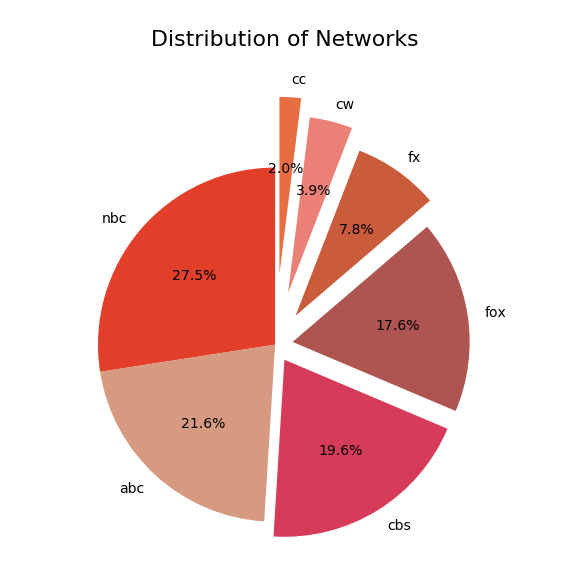

In [10]:
# Create a list of colors (from iWantHue)
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#E66E40"]

nets = df.network.value_counts()

# Create a pie chart
fig1, ax1 = plt.subplots(figsize = (8, 8)) #creating pie chart, setting size

patches, texts, autotext = ax1.pie(
    # using data total)arrests
    nets.values,
    # with the labels being officer names
    labels=nets.index,
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0, .1, .1, .2, .3, .4),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    #fontsize
    textprops={'fontsize': 14}
    )

# View the plot drop above
ax1.axis('equal')
plt.title('\n Distribution of Networks \n', fontsize = 22)
# View the plot
plt.tight_layout()
plt.show()

We have a total of 7 cable televion networks represented in our data. NBC has the most television shows in our dataframe (27.5%) while Comedy Central has the least (2% - or one show).  The bulk of the data (about 85%) seems to be pretty evenly split between four networks - NBC, ABC, CBS, and Fox.

<a id='interaction'></a>

## 2.3. Interactions

It's also helpful to see how variables interact with eachother. The first interaction that I want to examine is the number of people who viewed the season 1 pilot of a show versus the number of people who viewed the last episode of season 1 of a show. 

In [11]:
#creating copy of df with only the variables we want
pviews = df.viewpilot.values
fviews = df.viewseason1finale.values
dfview = pd.DataFrame(list(zip(pviews, fviews)), #setting titles and scripts as columns
              columns=['pilotview','fin1view'])
dfview['label'] = df['label'].values

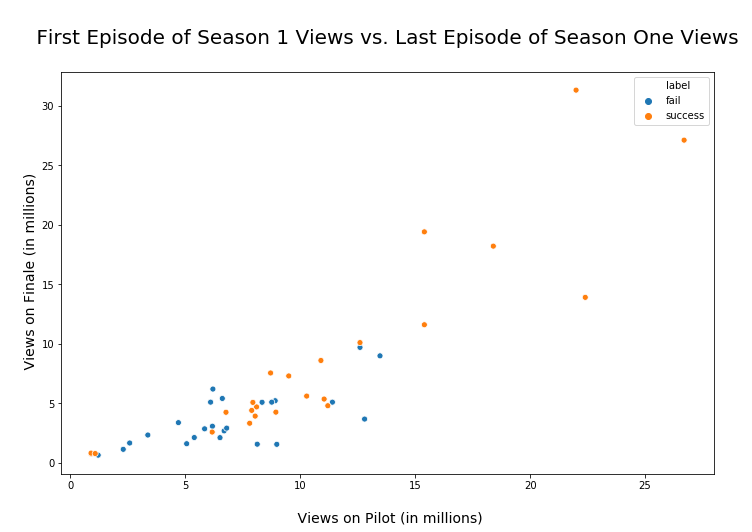

In [12]:
fig, ax = plt.subplots() #create figure
sns.scatterplot(x='pilotview',y='fin1view',hue='label',data=dfview) #reference our data
#layout
plt.subplots_adjust(top=0.8) 
fig.set_size_inches(11.7, 8.27)
#titles and labels
plt.title('\n First Episode of Season 1 Views vs. Last Episode of Season One Views \n', fontsize = 20)
plt.xlabel('\n Views on Pilot (in millions)', fontsize = 14)
plt.ylabel('\n Views on Finale (in millions)', fontsize = 14)
plt.show()

Initially, I was worried that some sitcoms would be more successful than others just because they started off with more viewers, but it appears that a lot of successful shows were just better at holding on to their viewers, despite not having huge ratings on their first episode either. One interesting difference that sticks out to me is that there were no failed sitcomss that had more than 15 million views on their pilot, while there are several successful sitcoms that did. As far as I know, a lot of these failed sitcoms were given a fighting chance by being cast in popular time-slots (such as Animal Practice, which aired directly after the Summer Olympics), so it's possible that people just weren't attracted by the premise or the ads for the show.

Text(0.5, 0.98, 'Rotten Tomatoes Scores by Network')

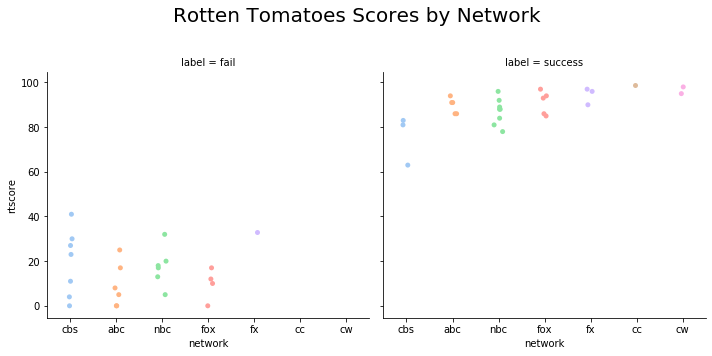

In [13]:
g = sns.catplot(x="network", y="rtscore", col="label", data=df, palette = 'pastel')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Rotten Tomatoes Scores by Network', fontsize = 20)

It looks like CBS has the most failed sitcoms while NBC has the lead on successful sitcoms. Both of the shows on the CW were successful as was the one show that was aired on Comedy Central. Most of the networks have more successful shows than failed shows, with the exception of CBS, which had more than double the number of failed shows than successful shows. The shows that were succesful on CBS also have lower rotten tomatoes scores than most of the other successful shows. 

<a id='text'></a>

## 3. EDA with Text Data

<a id='wordclouds'></a>

### 3.1.  WordClouds

WordClouds are a great way to visualize the frequencies of certain words in a text set. Let's see how the words that appear the most in our failed sitcoms differ from the words that appear the most in our successful sitcoms.

In [14]:
df_wc = df_raw.copy() #copy of df for manipulation

In [15]:
#remove "new line" characters
df_wc  = df_wc.replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n',  ' ', regex=True) #this one

In [16]:
#redefine these variables for our current df
bad = df_wc.loc[df_wc.label=='fail'] #unsuccessful shows
good = df_wc.loc[df_wc.label=='success'] #successful shows

Our WordCloud generator already has a built-in list of "stop words" that it uses to filter through our text data so we don't have two giant word clouds filled with words like "the" and "an". We are still going to add a few words to the stopwords list because I noticed some technical terms that are not part of pilot scripts slipped into our text data, such as the string "1x01".

In [17]:
#adding a few words to our stopwords list
stop_words = ['pilot', 'Pilot', "One", 'one', '1x01', 'directed', 'script', 'S01E01', 'dtype','object', 'ab'] + list(STOPWORDS)

For a bit of fun, let's also put our wordclouds into fun shapes by using wordclouds "mask feature". Both images used for masks in this project were found on google images and then worked on in Adobe PhotoShop to clean up the resolution so that our clouds would be clear and easy to read.

In [18]:
#our successful data will be in the shape of Homer Simpson's head, the main character from The Simpsons
homer_mask = np.array(Image.open("SIMPS3.png")) #generating numpy array
homer_mask #view array 

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

<a id='success'></a>

### 3.1.1. Successful Pilots WordCloud

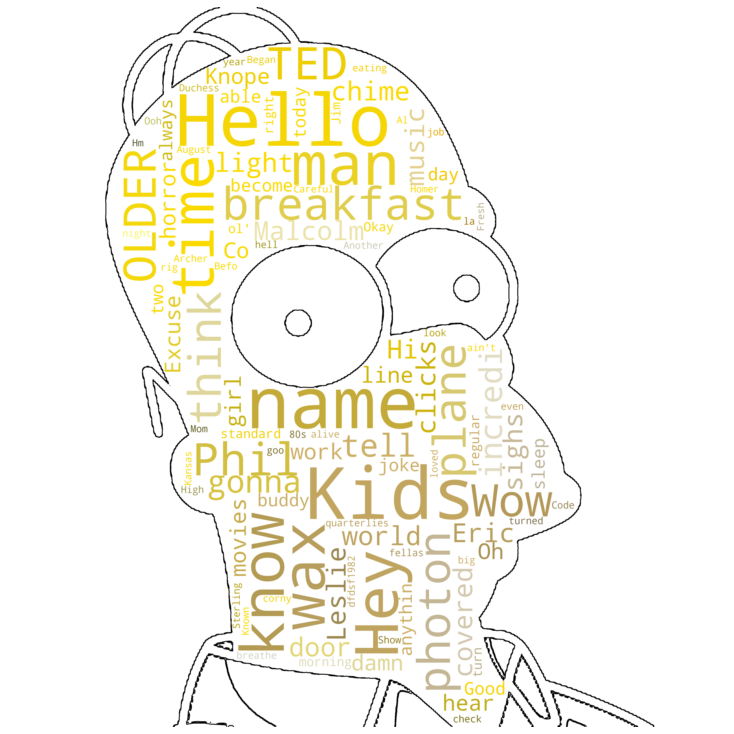

In [19]:
text = good.script #generate wordcloud from titles of successful projects

wordcloud = WordCloud(
    width = 400,
    height = 400,
    max_words = 250,
    mask=homer_mask,
    background_color = 'white',
    #min_word_length=3,
    stopwords = stop_words, contour_width=5, contour_color='black').generate(str(text)) #create figure, stopwords are words that words that will not be included

image_colors = ImageColorGenerator(homer_mask)
plt.figure(figsize = [10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation = 'bilinear') #this creates a streamlined layout
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

D'oh! There's Homer!

<a id='fail'></a>

### 3.1.2. Unsuccessful Pilots WordCloud

In [20]:
#Now let's create the mask for our failed sitcoms
#I'm using the shape of a court room gavel to represent one of our failed sitcoms- Bad Judge 
gavel_mask = np.array(Image.open("gavel.png")) #generate numpy array
gavel_mask #view mask array

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

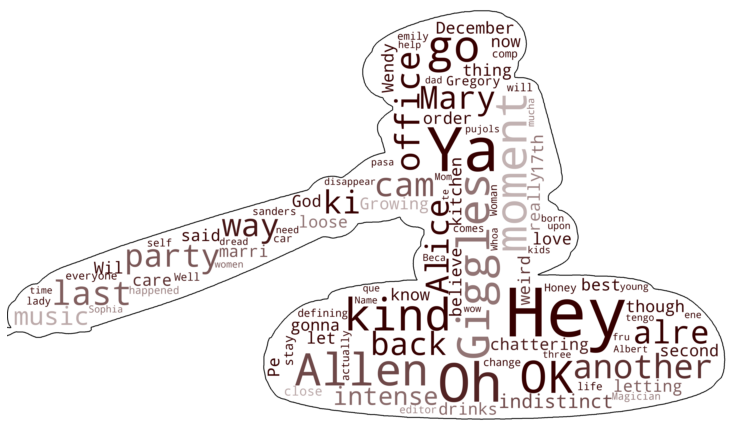

In [21]:
text = bad.script #generate wordcloud from titles of failed sitcoms

wordcloud = WordCloud(
    width = 400,
    height = 400,
    max_words = 250,
    mask=gavel_mask,
    background_color = 'white',
    #min_word_length=3,
    stopwords = stop_words, contour_width=5, contour_color='black').generate(str(text)) #create figure, stopwords are words that words that will not be included

image_colors = ImageColorGenerator(gavel_mask)
plt.figure(figsize = [10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation = 'bilinear') #this creates a streamlined layout
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

There are a number of differences between the two wordclouds. For example, one of the largest words in the successful cloud is "Hello", which doesn't even appear in the failed cloud.  The only greeting word in the failed cloud is the word "Hey", which also happens to be pretty much the largest word in the failed cloud. Maybe successful sitcoms have more formal characters? Or maybe the successful sitcoms have characters that interact with people they are less familiar with?

Another interesting difference between the wordclouds is that the word "kids" is very big in the successsful cloud but doesn't appear in the failed cloud. The failed cloud has more words like party and office, which may reflect that successful pilots usually involve more family dynamics while unsuccessful shows involve more content about young adults or individuals. 

There are some definite similiarities between the clouds as well. Both clouds feature a decent number of character names, such as "Archer" or "Malcolm" in the successful cloud and "Mary" and "Allen" in the failed cloud. This makes me think it may even be worth it in the future to see what kind of names audiences tend to prefer, seeing as the successful names seem to be less commonplace than the failed names.

<a id='lda'></a>

## 3.2. Latent Dirichlet Allocation (LDA)


Latent Dirichlet Allocation (LDA) is a NLP technique used to extract "topics" that appear in a set of text. In this context, a "topic" could be defined as a collection of dominant keywords that are typical representatives of a certain concept. Just by looking at the keywords, you can usually identify what the topic is. Our text data is filled with words that make up different topics, so our topic information is hidden, or in other words, our information is "latent".

In our short sitcom pilots (which average about 20 minutes long), we assume that each script will contain multiple topics, but we also assume that one episode is mainly centered around one topic. That's called a Dirichlet distribution.

LDA’s approach to topic modeling (in this context) revolves around defining each pilot script as a collection of topics in a certain proportion. Each topic is essentially a collection of keywords, again, in a certain proportion.

Once we provide the algorithm with the number of topics we want it to extract from our text data, it rearranges the topics distribution within the scripts and keywords distribution within the topics to create a solid composition of topic-keywords distribution.

In [22]:
df_lda = data_text #let's start by making copy of df for manipulation

In [23]:
# Convert text data to list
lda = df_lda.script.values.tolist()

The next step is to tokenize text and clean it up a little bit. Gensim's simple_preprocess function will help us accomplish this quickly.

In [24]:
#function to tokenize/clean data 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(lda))

Now it's time to make bigrams and trigrams. Bigrams are pairs of words that frequently appear together and trigrams are groups of three words that frequently appear together. A few examples of n-grams are "mouse traps", "oil leaks", or "West Covina, California". 

In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example for our first line
print(trigram_mod[bigram_mod[data_words[0]]]) 

['am', 'one', 'of', 'the', 'last', 'of', 'my', 'kind']


The bigrams model is done so our next step is to define the functions to remove the stopwords (which we have already imported for our WordCloud). After that, we will make bigrams, and lemmatize our text. 

In [26]:
# Define function for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Define function for bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Define function for trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#define function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's apply these functions sequentially to our data.

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['last', 'kind']]


Now that we have prepared the data for LDA, lets start building our model. 

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('kind', 1), ('last', 1)]]

Perfect, now let's move on to building our actual model!

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, #term doc frequency of our lemmatized_texts (which we set before)
                                           id2word=id2word, #dictionary (which we also set before)
                                           num_topics=20, #we set the number of topics to include to 20
                                           random_state=100, 
                                           update_every=1, #determines how often model parameters should be updated
                                           chunksize=100, #chunksize = number of lines to be used in each training chunk
                                           passes=10, #total number of training passes
                                           alpha='auto', #affects sparsity of topics, defaults to 1.0/num_topics
                                           per_word_topics=True)

The LDA model we built contains 20 different topics. Every topic is a combination of keywords, with each keyword contributing a certain weightage to the topic.

In [31]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"wtf" + 0.000*"musical" + 0.000*"somthing" + 0.000*"goal" + '
  '0.000*"soccer" + 0.000*"calendar" + 0.000*"soccergame" + 0.000*"afterwards" '
  '+ 0.000*"bb" + 0.000*"happend"'),
 (1,
  '0.354*"get" + 0.122*"re" + 0.099*"talk" + 0.088*"year" + 0.083*"give" + '
  '0.073*"last" + 0.057*"bad" + 0.000*"know" + 0.000*"let" + 0.000*"second"'),
 (2,
  '0.347*"thank" + 0.164*"friend" + 0.000*"big" + 0.000*"homer" + 0.000*"jar" '
  '+ 0.000*"boss" + 0.000*"back" + 0.000*"shower" + 0.000*"simpson" + '
  '0.000*"dear"'),
 (3,
  '0.405*"say" + 0.289*"time" + 0.046*"remember" + 0.015*"sell" + '
  '0.000*"fight" + 0.000*"let" + 0.000*"know" + 0.000*"start" + 0.000*"bring" '
  '+ 0.000*"merry"'),
 (4,
  '0.409*"call" + 0.092*"crazy" + 0.000*"maybe" + 0.000*"name" + '
  '0.000*"police" + 0.000*"tomorrow" + 0.000*"know" + 0.000*"laugh" + '
  '0.000*"phone" + 0.000*"make"'),
 (5,
  '0.434*"little" + 0.113*"day" + 0.084*"walk" + 0.038*"brother" + '
  '0.016*"close" + 0.000*"boy" + 0.000*"t

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v') #this number is bettee when it's higher
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) 


Perplexity:  -21.415006647887818

Coherence Score:  0.4620074201158052


A Coherence score of .46 is on the low side, but it's not terrible.

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.392064  0.319340       1        1  19.257231
10     0.149091 -0.440169       2        1  13.416137
1     -0.403275 -0.238737       3        1  11.914587
6     -0.187182  0.373425       4        1   8.009725
9      0.320384 -0.243412       5        1   6.182097
3      0.347307 -0.057362       6        1   5.979004
19     0.075268  0.364641       7        1   5.869223
13    -0.141007 -0.389462       8        1   5.693978
16    -0.371252  0.121734       9        1   4.284080
5      0.243622  0.126554      10        1   3.289726
18     0.151627 -0.006485      11        1   2.679528
15     0.030816  0.211700      12        1   2.472157
7     -0.214371 -0.100284      13        1   2.170409
2     -0.146315  0.153930      14        1   1.994904
4      0.039819 -0.162202      15        1   1.601699
8     -0.128628  0.078255      16        1   1.592246
11    -0.020500 -0.113045      17        1   1.411297
14    -0.113305 -0.022196      18        1   1.382527
12    -0.012230  0.011773      19        1   0.436362
0     -0.011932  0.012000      20        1   0.363084, topic_info=     Category         Freq         Term        Total  loglift  logprob
35    Default  5186.000000           go  5186.000000  30.0000  30.0000
20    Default  2257.000000          get  2257.000000  29.0000  29.0000
2     Default  1640.000000         come  1640.000000  28.0000  28.0000
104   Default  1297.000000          say  1297.000000  27.0000  27.0000
59    Default  1367.000000        think  1367.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
1882  Topic20     0.033891  unavailable     1.966493   1.5574  -8.6536
1883  Topic20     0.033891       square     1.966530   1.5574  -8.6536
1884  Topic20     0.033891     jeopardy     1.966493   1.5574  -8.6536
1885  Topic20     0.033891       parole     1.966493   1.5574  -8.6536
1886  Topic20     0.033891          cup     1.966493   1.5574  -8.6536

[2075 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
60        7  0.991349  actually
120       5  0.994857    always
143      11  0.986758      away
24        3  0.994163       bad
74        4  0.996621   believe
...     ...       ...       ...
38        9  0.997990     woman
27        9  0.977754      word
4         8  0.991408     world
119       3  0.997506      year
39        9  0.962240     young

[85 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 11, 2, 7, 10, 4, 20, 14, 17, 6, 19, 16, 8, 3, 5, 9, 12, 15, 13, 1])

On the left, we have bubbles representing each of our 20 topics. The size of the bubble corresponds with the prevalence of the topic, so topics 1, 2, 3, and 4 are our most talked about topics (which are each in a separate quadrant!).

While scanning over the keywords in our topics, it is tricky to determine exactly what our topics are. On the bright side, our plot displays lots of fairly large, non-overlapping bubbles scattered throughout the chart instead of all being clustered in one quadrant, which is a sign of a good topic model. Tiny bubbles that overlap each other and  cluster in a single region of the chart indicate that a model has too many topics.

This plot is also interactive, so if you move your cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

Our largest topic (topic 1), contains words such as "tomorrow", "want", "life", "go", "idea",  and "place". Because this is sitcom data, I am inclined to think that this topic is about discussing dreams or life-plans.  Future planning and goals are a central part of character development, so this makes sense to me.

Our smallest topic (topic 20), seems to be a little more spread out, but I interpret it as being about adventure, as it contains words such as "urgency", "bleeding", "terrorize", "unstoppable", "tuxedo" and "hungover". I would think that this is probably a smaller topic that seems to insert itself in a minimal way into many sitcom pilots, most likely acting as comedic relief; possibly popping up as a funny anecdote about a character's past.

<a id='feat'></a>

# 4. Feature Engineering

Now it's time to add additional features to our data through feature engineering. Python has a bunch of built in functions to extract information from string variables. We will apply these functions to the dataset and create new columns based off of them.

<a id='bfe'></a>

### 4.1. Basic Feature Engineering

The first features we add will be the more simple ones; ones that mostly revolve around using built-in functions to pandas, such as "isdigit", which reveals whether or not text has a number in it, or "len", which outputs the length (in characters) of a string. 

In [34]:
df_features = data_text.copy() #copy df for manipulation

In [35]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

#number of stopwords in line
df_features['stopwords'] = df_features['script'].apply(lambda x: len([x for x in x.split() if x in stop]))
#number of numbers in line
df_features['numerics'] = df_features['script'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
#number of upper case letters in line
df_features['upper'] = df_features['script'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
#number of words in line
df_features['word_count'] = df_features['script'].apply(lambda x: len(str(x).split(" ")))
#number of characters in line
df_features['length'] = df_features['script'].apply(lambda x : len(x)) 
#number of exclamation marks
df_features['num_exclamation_marks'] = df_features['script'].apply(lambda x: x.count('!'))
#number of question marks
df_features['num_question_marks'] = df_features['script'].apply(lambda x: x.count('?'))
#number of (remaining) punctuation marks
df_features['num_punctuation'] = df_features['script'].apply(lambda x: sum(x.count(w) for w in '.,;:'))

In [36]:
#create function to find average length of word in line
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))
#average length of word
df_features['avg_word'] = df_features['script'].apply(lambda x: avg_word(x))

<a id='box'></a>

<a id='complex'></a>

## 4.2. More Complex Features

I think that we have come up with some pretty good features already, but I would also like to add a few more variables that can help measure the content of what are text is saying on a higher level.

<a id='profanity'></a>

### 4.2.1. Profanity

The first thing that I am interested in is seeing how much profanity is in a script. To compile a list of "bad words", I used a list from the URL below that was created by Carnegie Mellon University. From their website, I believe that the list was created with the intent of helping people prevent hatespeech on their websites, as they describe the list as "A list of 1,300+ English terms that could be found offensive. The list contains some words that many people won't find offensive, but it's a good start for anybody wanting to block offensive or profane terms on their Site."

In [37]:
from urllib.request import urlopen 
#opening URL with list of controversial words
resp = urlopen("http://www.cs.cmu.edu/~biglou/resources/bad-words.txt")

In [38]:
#define list of obscenities
badwords = str(resp.read()).split('\\n') 

In [39]:
#apply function to dataframe
df_features['contro'] = df_features['script'].apply(lambda x: len([x for x in x.split() if x in badwords]))

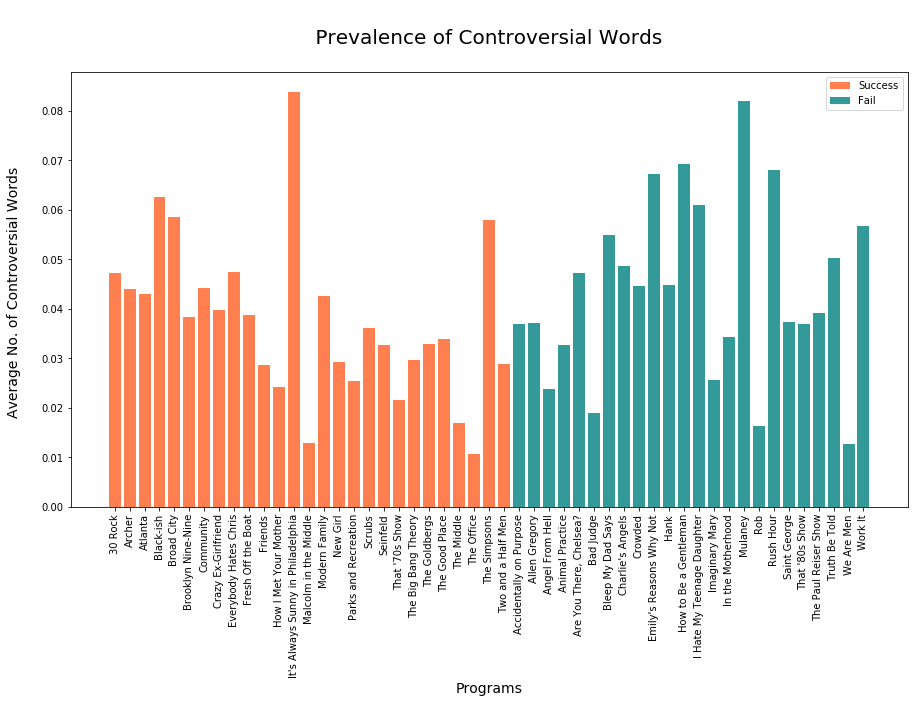

In [40]:
#grouping each label by average of names column
goodcontro = df_features[df_features['label']=='success'].groupby('title')['contro'].mean()
badcontro = df_features[df_features['label']=='fail'].groupby('title')['contro'].mean()
plt.figure(figsize=(15,8)) #plotting these two new groups on the same bar graph for comparison
plt.bar(goodcontro.index, goodcontro.values, alpha=1, label='Success', color='coral')
plt.bar(badcontro.index, badcontro.values, alpha=0.8, label='Fail', color='teal') #stylistic choices
plt.legend()
plt.title('\n Prevalence of Controversial Words \n', fontsize = 20) #title and labels
plt.xlabel('Programs', fontsize =14)
plt.ylabel('Average No. of Controversial Words \n', fontsize =14)
plt.xticks(rotation = 90)
plt.show()

<a id='human'></a>

### 4.2.2. Character Names

Another element of our text is the number of times characters' names are said. In a pilot, the television show is likely trying its hardest to establish characters and make an imprint on the audience. Additionally, I believe that the number of times a names are said might influence the amount of "ethos" a show has, as names can be humanizing and sometimes inspire empathy in people.

To create a column reflecting the number of times a name appears per line, I will be using the HumanName from nameparser which is a "A simple Python (3.2+ & 2.6+) module for parsing human names into their individual components.".

In [41]:
import nltk
from nameparser.parser import HumanName 

#creating name function
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text) #tokenize
    pos = nltk.pos_tag(tokens) #parts of speech
    sentt = nltk.ne_chunk(pos, binary = False) #create chunks
    person = [] #list of names
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0]) #add name to list

    return (len(person)) #return number of names

In [42]:
#creating new column of number of names in line
df_features['names'] = df_features['script'].apply(lambda x: get_human_names(x))

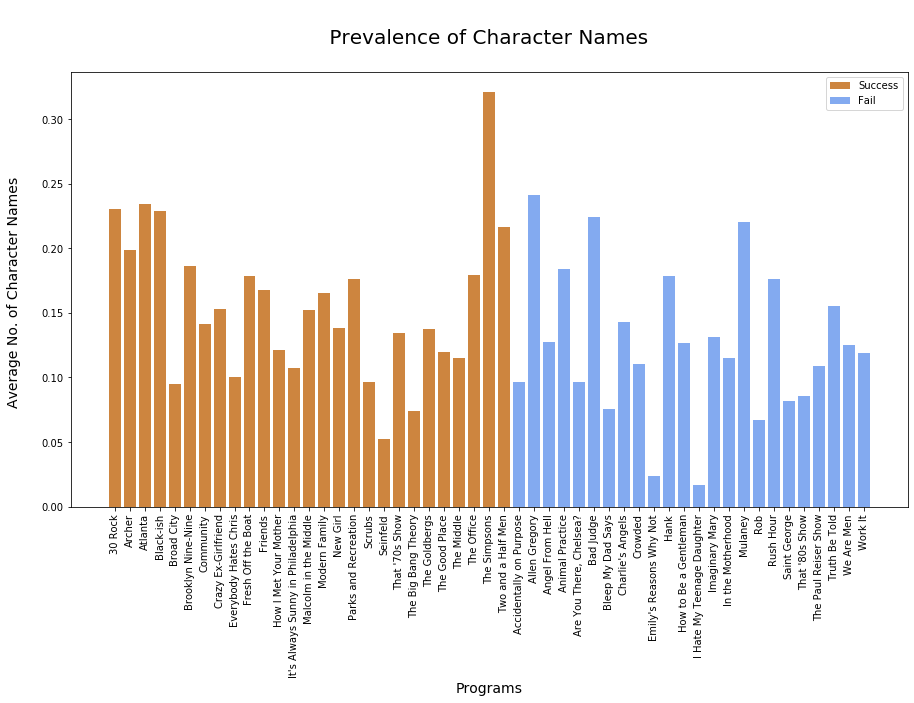

In [43]:
#grouping each label by average of names column
goodname = df_features[df_features['label']=='success'].groupby('title')['names'].mean()
badname = df_features[df_features['label']=='fail'].groupby('title')['names'].mean()
plt.figure(figsize=(15,8)) #plotting these two new groups on the same bar graph for comparison
plt.bar(goodname.index, goodname.values, alpha=1, label='Success', color='peru')
plt.bar(badname.index, badname.values, alpha=0.8, label='Fail', color='cornflowerblue') #stylistic choices
plt.legend()
plt.title('\n Prevalence of Character Names \n', fontsize = 20) #titles and labels
plt.xlabel('Programs', fontsize = 14)
plt.ylabel('Average No. of Character Names \n', fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

<a id='pos'></a>

### 4.2.3.  Part of Speech Tags

Another variable that we can measure in our text data is the frequency of various parts of speech. For this project, I am going to create a columns that display the number of nouns, verbs, and adjectives. To complete this, I will use NLTK's built in "pos tag", which will label the parts of speech for me. From there, I will take a look at few interactions, namely part of speech vs. the number of words in line.

In [44]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

#creating function to tag the parts of speech
def tag_part_of_speech(text):
    text_splited = text.split(' ') 
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited) #tag parts of speech 
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')]) #get number of nouns
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')]) #number of adjectives
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')]) #number of verbs
    return[noun_count, adjective_count, verb_count] 

In [45]:
#first get three separate columns for nouns, adjectives, and verbs
df_features['nouns'], df_features['adjectives'], df_features['verbs'] = zip(*df_features['script'].apply(
        lambda x: tag_part_of_speech(x)))

In [46]:
#creating additional POS features from existing features
df_features['nouns_vs_words'] = df_features['nouns'] / df_features['word_count']
df_features['adjectives_vs_words'] = df_features['adjectives'] / df_features['word_count']
df_features['verbs_vs_words'] = df_features['verbs'] / df_features['word_count']

<a id='confuse'></a>

## 4.3 Confusion Matrix for New Features

A lot of the features that we just created are pretty similiar. Let's make sure that none of these features are redundant by running a confusion matrix and checking for multi-collinearity between our new features.

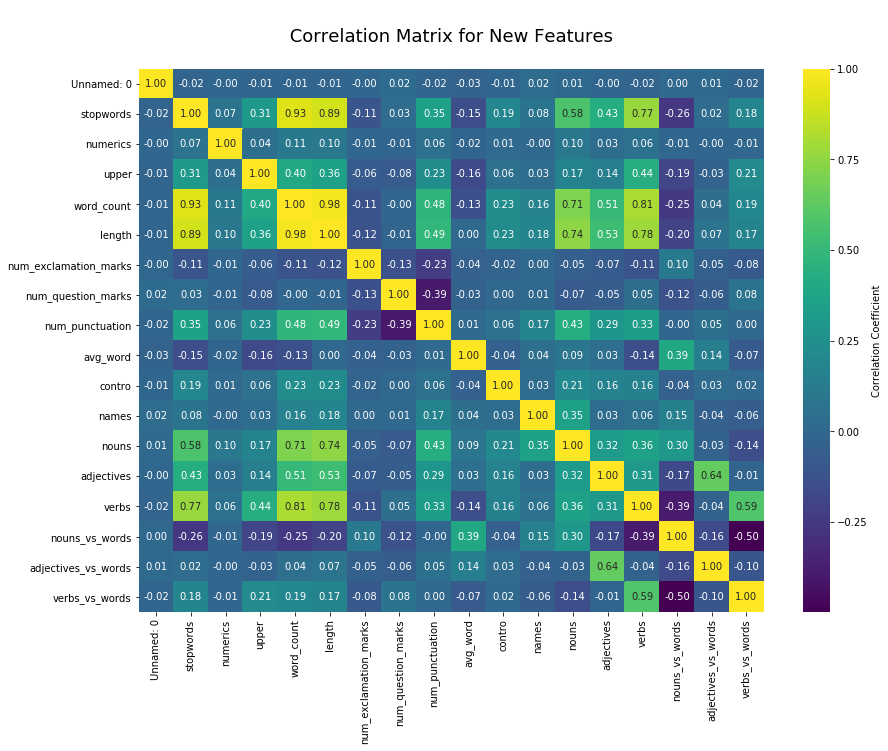

In [47]:
f, ax = plt.subplots(figsize= [14,10]) #creating confusion matrix
#drop script and label from our df for now
sns.heatmap(df_features.drop(['label','script'], axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("\n Correlation Matrix for New Features \n", fontsize=18) #title
bottom, top = ax.get_ylim() #adding fix for y-lim bug in current version of matplotlib
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

As expected, there seems to be a bit of noise in our data. I am going to drop the length and stopwords variables because they both have multiple correlation co-efficients that exceed .75. 

In [48]:
df_features = (df_features.drop(['stopwords', 'length'], axis=1)) #dropping stopwords and length from our dataframe

That should do it for creating new features! There are still a few things we need to do before we model our data - including some pre-processing techniques that we should apply. For now, let's save our work and get ready for the next notebook!

In [49]:
df_features.to_csv('pilotfeatures.csv') #saving the file to access it later